In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import randint as sp_randint
import joblib

# Load the dataset
df = pd.read_csv('heart_disease.csv')

# Check for missing values and fill them
df.fillna(df.mean(), inplace=True)


df.head(5)

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [2]:
# Exclude AnyHealthcare NoDocbcCost and Income columns
df = df.drop(['AnyHealthcare', 'NoDocbcCost','Income'], axis=1)

# Splitting the dataset into features (X) and target (y)
X = df.drop('HeartDiseaseorAttack', axis=1)
y = df['HeartDiseaseorAttack']

# Normalize and standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the model with RandomizedSearchCV
param_dist = {
    'n_estimators': sp_randint(100, 200),
    'max_depth': sp_randint(5, 20),
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 11),
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=50, cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

# Save the model and scaler
joblib.dump(best_model, 'heart_disease_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [4]:
# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.9083096814884895
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     45968
         1.0       0.61      0.07      0.12      4768

    accuracy                           0.91     50736
   macro avg       0.76      0.53      0.54     50736
weighted avg       0.88      0.91      0.87     50736



In [5]:
# Save the feature importance plot
import matplotlib.pyplot as plt
import os

def save_feature_importances(model, feature_names, output_file):
    if not os.path.exists(os.path.dirname(output_file)):
        os.makedirs(os.path.dirname(output_file))
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(10, 8))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.savefig(output_file)
    plt.close()

feature_names = X.columns.tolist()
save_feature_importances(best_model, feature_names, 'static/feature_importances.png')

In [10]:
#Optimising with Optuna

import optuna

# Load data
data = pd.read_csv('heart_disease.csv')
X = data.drop('HeartDiseaseorAttack', axis=1)
y = data['HeartDiseaseorAttack']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                                   random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # Reducing the number of trials can speed up the process

print('Best trial:', study.best_trial.params)

[I 2024-05-20 18:26:32,210] A new study created in memory with name: no-name-1921fb9e-2f02-4c25-878e-910c775e1ccb
[I 2024-05-20 18:27:09,136] Trial 0 finished with value: 0.9076001261431725 and parameters: {'n_estimators': 139, 'max_depth': 35, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9076001261431725.
[I 2024-05-20 18:27:45,990] Trial 1 finished with value: 0.9075409965310628 and parameters: {'n_estimators': 128, 'max_depth': 89, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9076001261431725.
[I 2024-05-20 18:28:12,837] Trial 2 finished with value: 0.9075804162724692 and parameters: {'n_estimators': 91, 'max_depth': 44, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9076001261431725.
[I 2024-05-20 18:28:29,459] Trial 3 finished with value: 0.908349101229896 and parameters: {'n_estimators': 61, 'max_depth': 34, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 3 with value: 

Best trial: {'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 3}


In [11]:
# Save study results to a DataFrame
study_results = study.trials_dataframe()

# Save the DataFrame to a CSV file
study_results.to_csv('optuna_study_results.csv', index=False)

print('Best trial:', study.best_trial.params)

Best trial: {'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 3}


In [12]:

# Retrain the model with the best parameters
final_model = RandomForestClassifier(n_estimators=100, max_depth=14, min_samples_split=5, min_samples_leaf=3, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print(f'Final Model Accuracy: {final_accuracy}')

# Save the model
joblib.dump(final_model, 'final_random_forest_model.joblib')

# Example of loading the model
loaded_model = joblib.load('final_random_forest_model.joblib')

Final Model Accuracy: 0.9085067801955219


C:\Users\maria\AppData\Local\Temp\ipykernel_23400\733962356.py:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


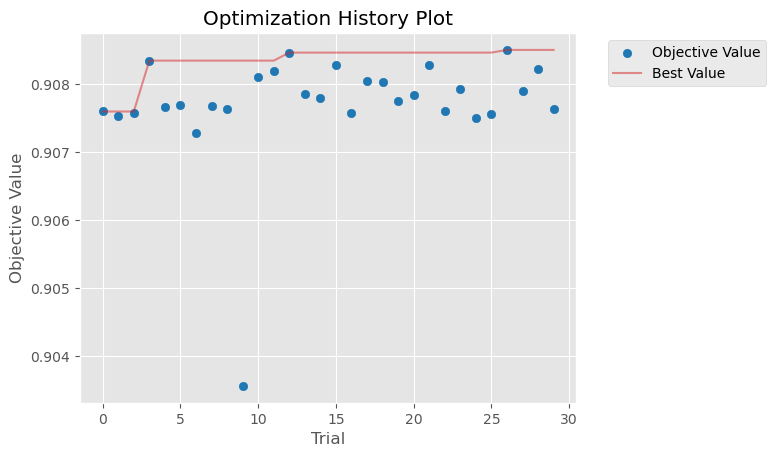

C:\Users\maria\AppData\Local\Temp\ipykernel_23400\733962356.py:11: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


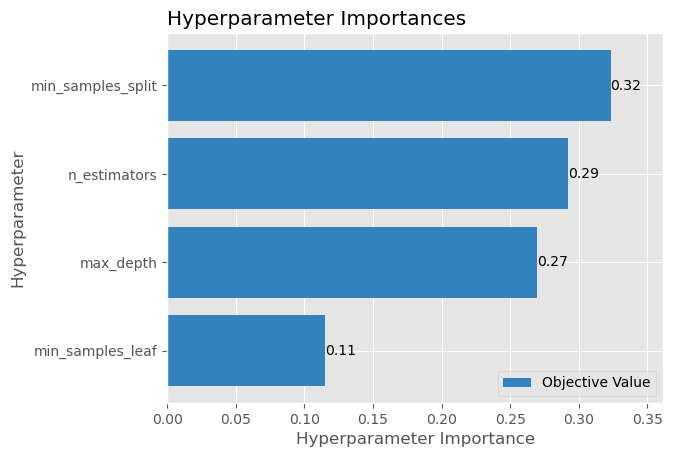

C:\Users\maria\AppData\Local\Temp\ipykernel_23400\733962356.py:17: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


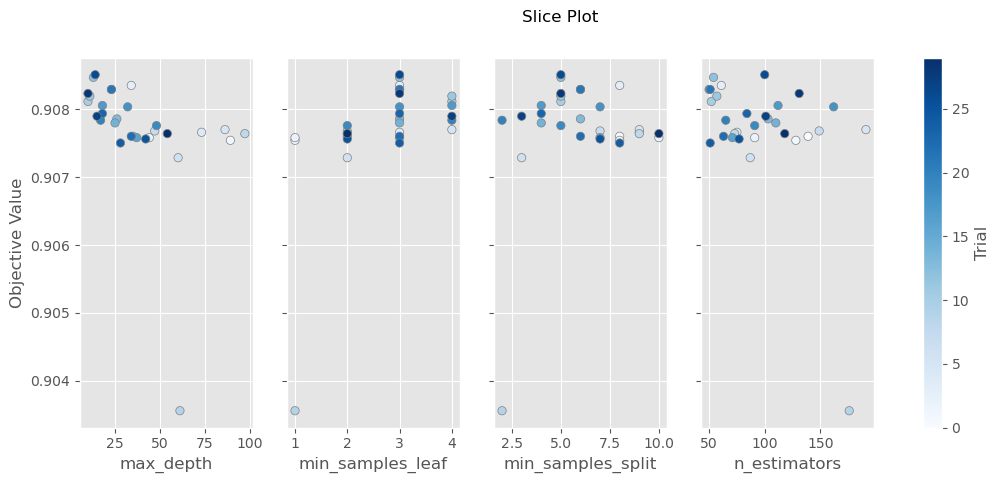

C:\Users\maria\AppData\Local\Temp\ipykernel_23400\733962356.py:23: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=['n_estimators', 'max_depth'])
[W 2024-05-20 19:46:25,102] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


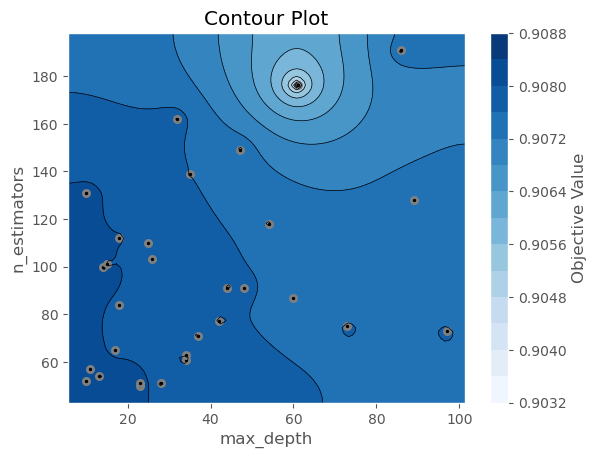

In [17]:
#Optuna Model Visualisations


# Optimization history plot
optuna.visualization.matplotlib.plot_optimization_history(study)
#Save image
plt.savefig("Optuna_Optimization_History_Plot.png", bbox_inches='tight')  
plt.show()

# Hyperparameter importance plot
optuna.visualization.matplotlib.plot_param_importances(study)
#Save image
plt.savefig("Optuna_Hyperparameter_Importance_Plot.png", bbox_inches='tight')  
plt.show()

# Slice plot
optuna.visualization.matplotlib.plot_slice(study)
#Save image
plt.savefig("Optuna_Slice_Plot.png", bbox_inches='tight')  
plt.show()

# Contour plot of two hyperparameters
optuna.visualization.matplotlib.plot_contour(study, params=['n_estimators', 'max_depth'])
#Save image
plt.savefig("Optuna_Contour_plot_of_two_hyperparameters.png", bbox_inches='tight')  

plt.show()